<a href="https://colab.research.google.com/github/lokeshkumarn/Notebooks/blob/master/DL_MovieReview_DropOut_Moved.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Libraries/Dataset

### Import Libraries

In [1]:
import time
import tensorflow as tf
from tensorflow.python.client import device_lib
from google.colab import drive

import pandas as pd
import numpy as np
import random as rd

from tensorflow import keras

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report

from matplotlib import pyplot as plt

In [2]:
rd.seed(2020)         # Initialize the random number generator.
np.random.seed(2020)      # With the seed reset, the same set of numbers will appear every time. 
tf.random.set_seed(2020)  # sets the graph-level random seed

### Import Dataset

Load dataset from Google Drive

In [3]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
df = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/Dataset/IMDB Dataset.csv')

In [5]:
df.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


In [6]:
df.shape

(50000, 2)

### Check GPU

In [7]:
def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU' ]

gpu_lst = get_available_gpus()

if(len(gpu_lst) > 0):
  print("GPU Enabled")

GPU Enabled


## Data Visualization

### Print Reviews

Print at least two movie reviews from each class of the dataset, for a sanity check that labels match the text

In [8]:
print("Positive Reviews")
print("*"*30)
for i,r in df[df['sentiment'] =='positive'].reset_index()[:3].iterrows():
  print(i + 1,")",r['review'])
  print("\n")

print("Negative Reviews")
print("*"*30)
for i,r in df[df['sentiment'] =='negative'].reset_index()[:3].iterrows():
  print(i + 1,")",r['review'])
  print("\n")

Positive Reviews
******************************
1 ) One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I wou

### Plot Class Distribution

Plot a bar graph of class distribution in dataset. Each bar depicts the number of tweets belonging to a particular sentiment.

Text(0, 0.5, 'Sentiment')

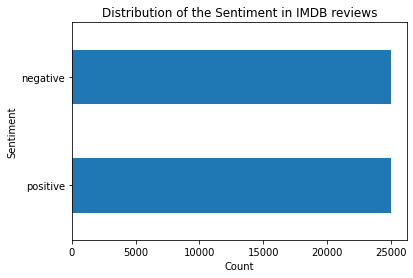

In [9]:
ax = plt.subplot()
df['sentiment'].value_counts().plot(kind='barh',ax=ax)
ax.set_title("Distribution of the Sentiment in IMDB reviews")
ax.set_xlabel("Count")
ax.set_ylabel("Sentiment")

### Print the shapes of train and test data

In [10]:
df['class'] = df['sentiment'].apply(lambda x:  1 if x=='positive' else 0)

In [11]:
X = df['review'].values
y = df['class'].values
print(X.shape)
print(y.shape)

(50000,)
(50000,)


In [12]:
X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                 test_size=0.3,
                                                 shuffle=True,
                                                 stratify=y,
                                                 random_state=2020)

In [13]:
print('Train Features shape:',X_train.shape)
print('Test Features shape:',X_test.shape)
print('Train label shape:',y_train.shape)
print('Test label shape:',y_test.shape)

Train Features shape: (35000,)
Test Features shape: (15000,)
Train label shape: (35000,)
Test label shape: (15000,)


Text(0, 0.5, 'Sentiment')

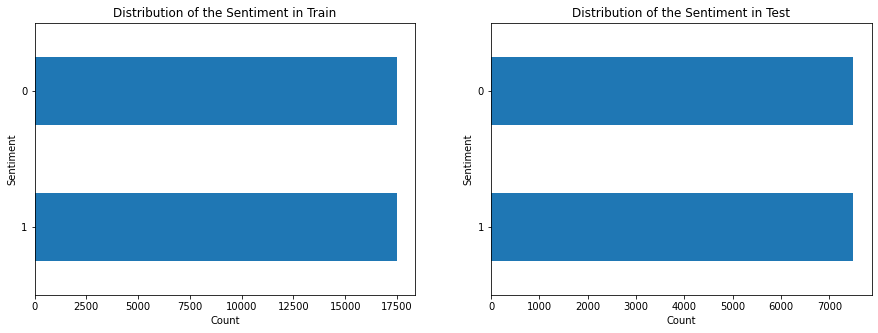

In [14]:
#Verify whether stratification worked
fig,ax = plt.subplots(1,2,figsize=(15,5))
pd.Series(y_train).value_counts().plot(kind='barh',ax=ax[0])
pd.Series(y_test).value_counts().plot(kind='barh',ax=ax[1])
ax[0].set_title("Distribution of the Sentiment in Train")
ax[0].set_xlabel("Count")
ax[0].set_ylabel("Sentiment")
ax[1].set_title("Distribution of the Sentiment in Test")
ax[1].set_xlabel("Count")
ax[1].set_ylabel("Sentiment")

## Data Pre-processing

Need for this Step - Since the models we use cannot accept string inputs or cannot be of the string format. We have to come up with a way of handling this step.

Using the Pretrained embedding layer to convert the sentence to vector

In [15]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string)

## Modeling

### Model Building

Sequential Model layers

In [16]:
model = keras.Sequential()

1.   Add L2 regularization to all the layers.
2.   Add one layer of dropout at the appropriate position and give reasons.
3.   Choose the appropriate activation function for all the layers.

**Choose the best number for hidden units and give reasons.**<br>
1.The number of hidden neurons should be between the size of the input layer and the size of the output layer.<br>
2.The number of hidden neurons should be 2/3 the size of the input layer, plus the size of the output layer.<br>
3.The number of hidden neurons should be less than twice the size of the input layer.<br>

Reference : [Link](https://www.heatonresearch.com/2017/06/01/hidden-layers.html)


**Give reasons for the dropout**<br>
Dropout of **0.3** is to drastically reduce the parameters and also generalize better on the unseen data points

In [17]:
hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/1",output_shape=128,
                           input_shape=[], dtype=tf.string)

model = keras.Sequential()

model.add(hub_layer)

model.add(keras.layers.Dense(64, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)) )

model.add(keras.layers.Dropout(0.3)) #moved one layer above and reduced to 30%

model.add(keras.layers.Dense(32, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)))


model.add(keras.layers.Dense(16, activation='relu',kernel_regularizer=keras.regularizers.l2(0.01),
                activity_regularizer=keras.regularizers.l2(0.01)))

model.add(keras.layers.Dense(1, activation='sigmoid'))

Moved the dropout layer one layer above and reduced the percentage to 30%

Print the model summary

In [18]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               249285376 
_________________________________________________________________
dense (Dense)                (None, 64)                8256      
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 249,296,257
Trainable params: 10,881
Non-trainable params: 249,285,376
___________________________________

### Model Compilation

**Loss** : Binary Cross Entropy (because it's a binary classification problem <br/>
**Optimizer**: Adam  is an extension of the stochastic gradient descent and seen extensivelty used in Natural language processing. it has adaptive learning rate.


In [19]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001,name='Adam'),#Use an appropriate optimizer
              loss='binary_crossentropy',#appropriate loss function
              metrics=['accuracy'])#Use accuracy as metric

**Give reasons for the choice of learning rate and its value**<br>
Learning rate of 0.001 is choosen, because too high would rollover the minima and I have tried giving the higher learning rate like 0.4, 0.2, 0.1, 0.01 the loss doesn't seem to converge to minima, so decided to lower the learning rate further so that weight update is minimum and proceeds towards the convergence or global minima 

### Model Training 

Train the model for an appropriate number of epochs (print the train and validation accuracy/loss for each epoch). Use the appropriate batch size

In [20]:
start_train = time.time()
history = model.fit(X_train,
                    y_train,
                    epochs=50,
                    batch_size=1000,
                    validation_split=0.2,
                    verbose=1)
end_train = time.time()

Epoch 1/50
28/28 [==============================] - 2s 62ms/step - loss: 1.9510 - accuracy: 0.4799 - val_loss: 1.6931 - val_accuracy: 0.5281
Epoch 2/50
28/28 [==============================] - 2s 57ms/step - loss: 1.5118 - accuracy: 0.5454 - val_loss: 1.3413 - val_accuracy: 0.6093
Epoch 3/50
28/28 [==============================] - 2s 56ms/step - loss: 1.2216 - accuracy: 0.6203 - val_loss: 1.1078 - val_accuracy: 0.6744
Epoch 4/50
28/28 [==============================] - 2s 58ms/step - loss: 1.0273 - accuracy: 0.6806 - val_loss: 0.9484 - val_accuracy: 0.7170
Epoch 5/50
28/28 [==============================] - 2s 56ms/step - loss: 0.8894 - accuracy: 0.7206 - val_loss: 0.8262 - val_accuracy: 0.7480
Epoch 6/50
28/28 [==============================] - 2s 57ms/step - loss: 0.7800 - accuracy: 0.7530 - val_loss: 0.7292 - val_accuracy: 0.7700
Epoch 7/50
28/28 [==============================] - 2s 55ms/step - loss: 0.7021 - accuracy: 0.7729 - val_loss: 0.6717 - val_accuracy: 0.7767
Epoch 8/50
28

Plot the loss and accuracy history graphs

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


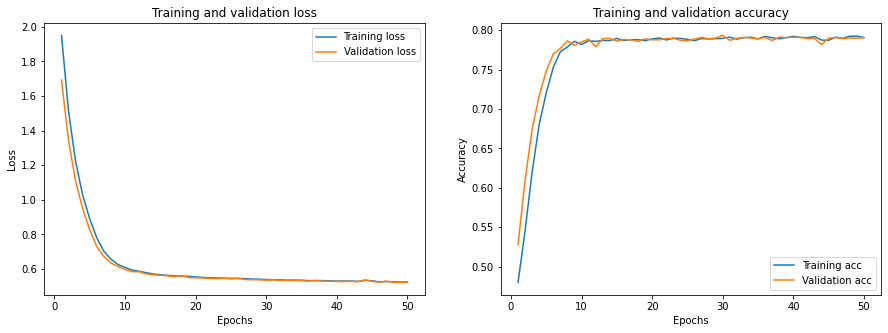

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

fix,ax = plt.subplots(1,2, figsize=(15,5))
ax1 = ax[0] # to plot Training Loss
ax2 = ax[1] # to plot Training Accuracy
ax1.plot(epochs, loss, label='Training loss')
ax1.plot(epochs, val_loss,  label='Validation loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(epochs, acc, label='Training acc')
ax2.plot(epochs, val_acc,  label='Validation acc')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()

plt.show()

In [22]:
#Time taken to train
print("Time taken to train the NN:",end_train - start_train," seconds")

Time taken to train the NN: 83.91376066207886  seconds


### Model Evaluation

Print the final test/validation loss and accuracy

In [23]:
results = model.evaluate(X_test, y_test)

print("Test Loss:",results[0])
print("Test Accuracy:",results[1])

469/469 [==============================] - 2s 5ms/step - loss: 0.5186 - accuracy: 0.7963
Test Loss: 0.518595814704895
Test Accuracy: 0.7963333129882812


In [24]:
#Predictions
y_pred = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


Confusion Matrix

In [25]:
print("Confustion Matrix")
print(confusion_matrix(y_test,y_pred))

Confustion Matrix
[[5988 1512]
 [1543 5957]]


In [26]:
y_pred = [v[0] for v in y_pred]

In [27]:
df = pd.DataFrame({'y_test':y_test,'y_pred':y_pred})
df.head()
confusion_matrix = pd.crosstab(df['y_test'], df['y_pred'], rownames=['Actual'], colnames=['Predicted'])
print (confusion_matrix)

Predicted     0     1
Actual               
0          5988  1512
1          1543  5957


Classification Report

In [28]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      7500
           1       0.80      0.79      0.80      7500

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000



**Write a summary for the best and worst performing class and the overall trend??**

Its difficult to compare the best and worst class in this model results as both of them where having similar F1-score and also from the confusion matrix it is evident that both have more or less closer FP and FN rates <br>
In the 10 epochs itself the loss and accuracy saturated